# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler


2024-12-02 20:11:45.094554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 20:11:45.113597: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 20:11:45.377488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 20:11:45.561603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733170305.871956   17495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733170305.93

Quick glance at how many entries of each label (Navigational Status) are in the dataset.

In [2]:
import os
import pandas as pd

# Load Data
folder_path = "area_vessels"
files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Combine data from all CSVs
data = []
for file in files:
    print(f"Loading file: {file}")  # Debugging: Print file being processed
    df = pd.read_csv(file, comment='#')
    print(f"Columns in {file}: {df.columns}")  # Debugging: Print columns of each file
    data.append(df[['MMSI', 'Timestamp', 'Latitude', 'Longitude', 'SOG', 'COG', 'Heading', 'Navigational status']])
data = pd.concat(data)

print("Columns in data:", data.columns)
print("Sample of the data:\n", data.head())

# Drop missing Navigational Status values if any
if data['Navigational status'].isna().sum() > 0:
    print(f"Warning: Found {data['Navigational status'].isna().sum()} missing entries for Navigational status. Dropping them.")
    data = data.dropna(subset=['Navigational status'])

# Summarize the counts for each Navigational Status
status_counts = data['Navigational status'].value_counts()

# Print the summary
print("\nNavigational Status Counts:")
print(status_counts)


Loading file: area_vessels/mmsi_374689000.csv
Columns in area_vessels/mmsi_374689000.csv: Index(['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
       'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',
       'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D'],
      dtype='object')
Loading file: area_vessels/mmsi_205689000.csv
Columns in area_vessels/mmsi_205689000.csv: Index(['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
       'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',
       'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D'],
      dtype='object')
Loading file: area_vessels/mmsi_219033037.csv
Columns in area_vessels/mmsi_219033037.csv: Index(['Timestam

## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]
For multi-class classification: Linear regression is not suitable at all. Methods like one-vs-rest (OvR) logistic regression, decision trees, or support vector machines should be considered instead.


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]

I take [position, course, heading and speed] over time because it is my aim to get predictions for these inputs.


In [5]:
# Convert Timestamp to datetime
print("Converting Timestamp to datetime...")
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
missing_timestamps = data['Timestamp'].isna().sum()
if missing_timestamps > 0:
    print(f"Warning: {missing_timestamps} rows have invalid timestamps and will be dropped.")
data = data.dropna(subset=['Timestamp'])
print(f"Total rows after dropping invalid timestamps: {len(data)}")
# Debugging: Check rows after cleaning
print("Columns in data:", data.columns)
print("Sample of the data:\n", data.head())

# Filter Data for Timeslot (30 minutes)
timeslot_minutes = 30
# Sort by MMSI and Timestamp
data = data.sort_values(by=['MMSI', 'Timestamp'])
# Create 30-minute time intervals for each vessel
data['Time_Group'] = data.groupby('MMSI')['Timestamp'].transform(
    lambda x: (x - x.min()).dt.total_seconds() // (timeslot_minutes * 60)
)

# Check consistency of Navigational Status within each MMSI and Time_Group
def is_status_consistent(group):
    return group['Navigational status'].nunique() == 1

# Filter for consistent groups
consistent_groups = data.groupby(['MMSI', 'Time_Group']).filter(is_status_consistent)

# Debugging: Check how many consistent groups remain
print(f"Number of consistent groups: {len(consistent_groups)}")


# Aggregate Features
grouped = consistent_groups.groupby(['MMSI', 'Time_Group']).agg({
    'Latitude': ['mean', 'std'],
    'Longitude': ['mean', 'std'],
    'SOG': ['mean', 'std'],
    'COG': ['mean', 'std'],
    'Heading': ['mean', 'std'],
    'Navigational status': 'first'  # Assume it stays constant within the group
}).dropna()  # Drop incomplete groups

# Flatten MultiIndex Columns
grouped.columns = ['_'.join(col).strip() for col in grouped.columns]
grouped.reset_index(inplace=True)

# Debugging: Check aggregated data
print(f"Aggregated data contains {len(grouped)} groups.")
print("Sample of the aggregated dataset:")
print(grouped.head(3))

# Split Features and Target
X = grouped.drop(columns=['Navigational status_first'])
y = grouped['Navigational status_first']

# Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Undersample the majority class
# from imblearn.under_sampling import RandomUnderSampler

# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y_encoded)

# Verify the new class distribution
from collections import Counter
# print(f"Original Class Distribution: {Counter(y_encoded)}")
# print(f"Resampled Class Distribution: {Counter(y_resampled)}")

print(f"Original Class Distribution: {Counter(y_encoded)}")
# Debugging: View aggregated data before normalization
print("Aggregated data (before normalization):")
print(grouped.head(10))  # Display the first 10 rows
print(f"Shape of the aggregated dataset: {grouped.shape}")

# Optionally, display summary statistics
print("\nSummary statistics of aggregated data:")
print(grouped.describe())


# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Sample of normalized features:")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

Converting Timestamp to datetime...
Total rows after dropping invalid timestamps: 230960
Columns in data: Index(['MMSI', 'Timestamp', 'Latitude', 'Longitude', 'SOG', 'COG', 'Heading',
       'Navigational status', 'Time_Group'],
      dtype='object')
Sample of the data:
         MMSI           Timestamp   Latitude  Longitude  SOG   COG  Heading  \
0  205689000 2024-11-26 00:02:37  55.226567  11.754950  0.0  22.0     22.0   
1  205689000 2024-11-26 00:05:38  55.226533  11.755000  0.0  22.0     22.0   
2  205689000 2024-11-26 00:07:17  55.226533  11.755000  0.0  22.0     22.0   
3  205689000 2024-11-26 00:08:38  55.226517  11.754967  0.0  22.0     22.0   
4  205689000 2024-11-26 00:11:38  55.226550  11.755033  0.0  22.0     22.0   

  Navigational status  Time_Group  
0              Moored         0.0  
1              Moored         0.0  
2              Moored         0.0  
3              Moored         0.0  
4              Moored         0.0  
Number of consistent groups: 219999
Aggrega

## Implementation

[Implement your baseline model here.]



In [6]:
# Build the Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with softmax
])

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)





Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-02 20:21:46.888342: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7909 - loss: 0.8301 - val_accuracy: 0.8945 - val_loss: 0.3725
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9090 - loss: 0.3171 - val_accuracy: 0.8966 - val_loss: 0.3271
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2753 - val_accuracy: 0.8966 - val_loss: 0.2987
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9229 - loss: 0.2450 - val_accuracy: 0.8966 - val_loss: 0.2915
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2595 - val_accuracy: 0.8945 - val_loss: 0.2666
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9277 - loss: 0.2312 - val_accuracy: 0.8945 - val_loss: 0.2451
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9204 - loss: 0.2238 - val_accuracy: 0.9093 - val_loss: 0.2358
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9329 - loss: 0.2193 - val_accuracy: 0.9156 - val_loss: 0.2177
Epo

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9651 - loss: 0.0905 
Test Accuracy: 0.97


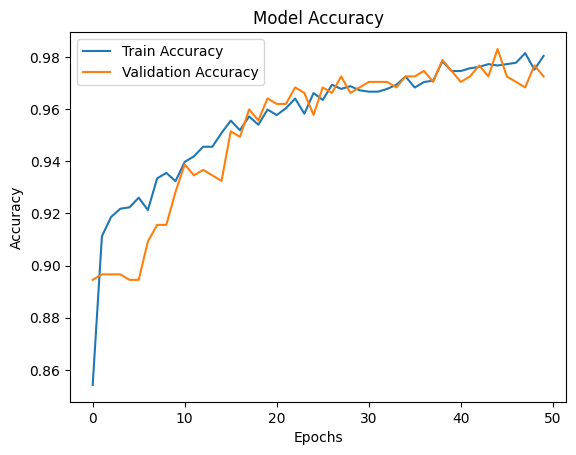

In [7]:
import matplotlib.pyplot as plt

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


Visualizations to understand what the model does.

In [9]:
# Combine features and target into one DataFrame for clarity
input_output = pd.concat(
    [pd.DataFrame(X, columns=grouped.drop(columns=['Navigational status_first']).columns),
     pd.DataFrame(y, columns=['Target (Navigational status)'])],
    axis=1
)

# Display a sample
print("Sample of the data fed into the model:")
print(input_output.head(10))  # Display the first 10 rows


Sample of the data fed into the model:
        MMSI  Time_Group  Latitude_mean  Latitude_std  Longitude_mean  \
0  205689000         0.0      55.226530      0.000027       11.754968   
1  205689000         1.0      55.226539      0.000029       11.754962   
2  205689000         2.0      55.226540      0.000018       11.754979   
3  205689000         3.0      55.226553      0.000020       11.754981   
4  205689000         4.0      55.226543      0.000015       11.754966   
5  205689000         5.0      55.226545      0.000028       11.754937   
6  205689000         6.0      55.226562      0.000025       11.754986   
7  205689000         7.0      55.226560      0.000013       11.754978   
8  205689000         8.0      55.226548      0.000021       11.755001   
9  205689000         9.0      55.226574      0.000018       11.754953   

   Longitude_std  SOG_mean  SOG_std   COG_mean   COG_std  Heading_mean  \
0       0.000040       0.0      0.0  22.000000  0.000000     22.000000   
1       0

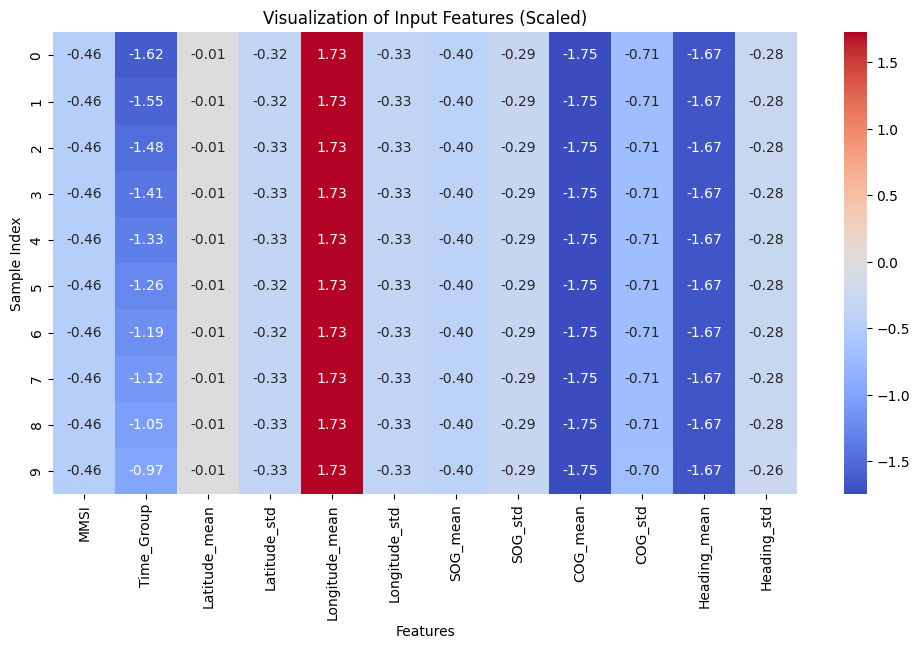

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize a subset of the scaled feature matrix
plt.figure(figsize=(12, 6))
sns.heatmap(pd.DataFrame(X_scaled[:10], columns=grouped.drop(columns=['Navigational status_first']).columns),
            annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Visualization of Input Features (Scaled)")
plt.xlabel("Features")
plt.ylabel("Sample Index")
plt.show()


Visualize Feature vs Target

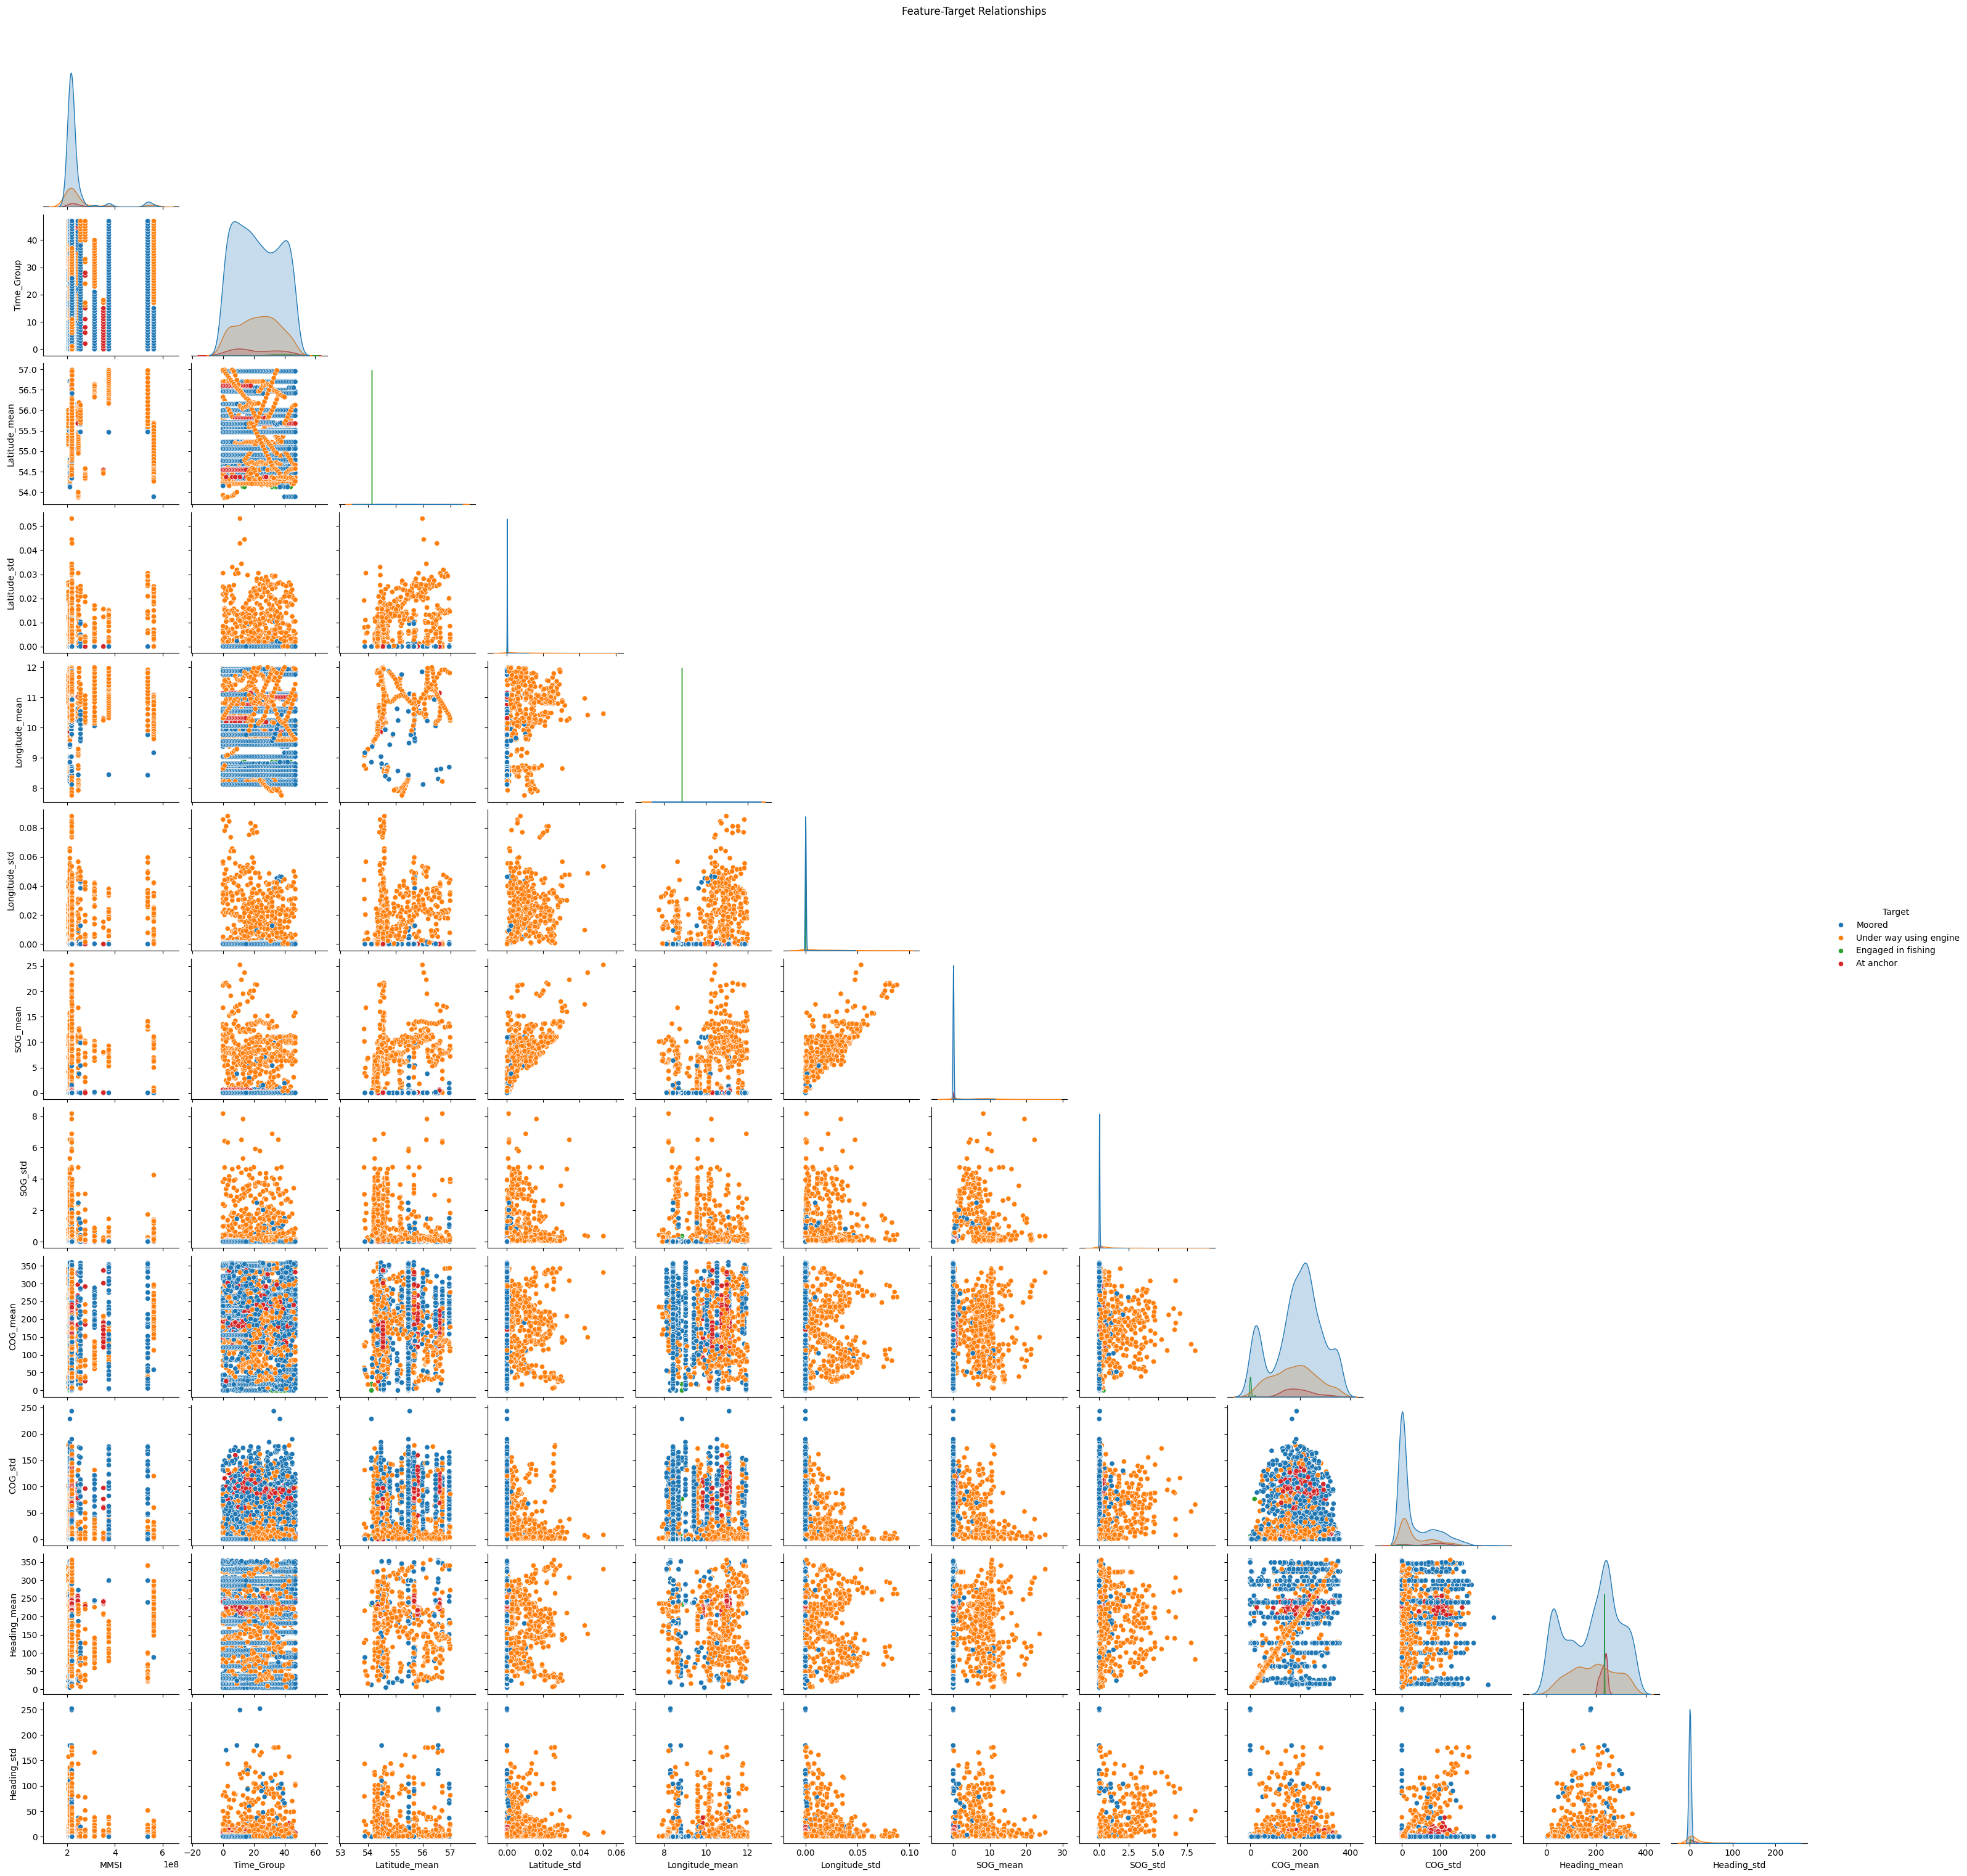

In [11]:
# Add target back to the feature DataFrame
visualization_data = pd.DataFrame(X, columns=grouped.drop(columns=['Navigational status_first']).columns)
visualization_data['Target'] = y

# Plot a pairplot to observe feature-target relationships
sns.pairplot(visualization_data, hue='Target', diag_kind='kde', corner=True)
plt.suptitle("Feature-Target Relationships", y=1.02)
plt.show()


Inspect one sample

In [13]:
# Choose a random sample (e.g., index 0)
sample_idx = 42

print("Single Input-Output Example:")
print("Input Features:")
print(pd.DataFrame([X[sample_idx]], columns=grouped.drop(columns=['Navigational status_first']).columns))
print("\nTarget (Navigational Status):")
print(f"Label: {y[sample_idx]}")
print(f"Categorical: {y_categorical[sample_idx]}")


Single Input-Output Example:
Input Features:


KeyError: 42

Visualize Class distribution

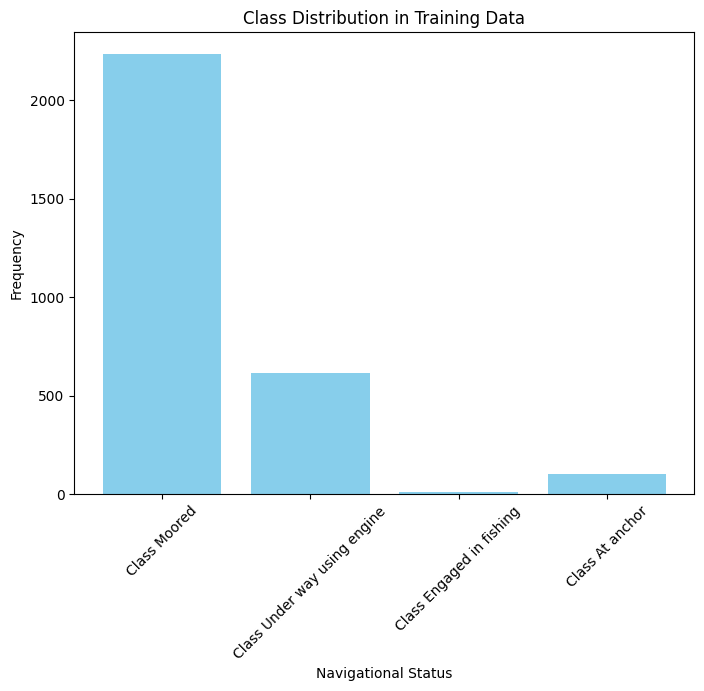

In [14]:
from collections import Counter
import numpy as np

# Count each class in the target
class_counts = Counter(y_encoded)
labels = [f"Class {le.inverse_transform([key])[0]}" for key in class_counts.keys()]

plt.figure(figsize=(8, 6))
plt.bar(labels, class_counts.values(), color='skyblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Navigational Status")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


Yes, a simpler model like logistic regression or linear regression (with a softmax function) can work for this task, especially if the relationships between the input features (Latitude, Longitude, SOG, COG, and Heading) and the Navigational Status are mostly linear.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Preprocess Data (Assuming 'data' DataFrame is already loaded and cleaned as above)
X = grouped.drop(columns=['Navigational status_first'])
y = grouped['Navigational status_first']

# Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9155405405405406
Classification Report:
                         precision    recall  f1-score   support

             At anchor       0.00      0.00      0.00        21
    Engaged in fishing       1.00      0.67      0.80         3
                Moored       0.91      0.99      0.95       455
Under way using engine       0.96      0.79      0.86       113

              accuracy                           0.92       592
             macro avg       0.72      0.61      0.65       592
          weighted avg       0.89      0.92      0.90       592



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-pa

Conclusion:

The model shows good performance for one of the classes but struggles significantly with class imbalance. Implementing methods like class balancing (via resampling or class weights), exploring cross-validation, and possibly switching to a more complex model should improve the model’s ability to classify all the categories accurately.